# Sentiment Analysis: Using Hugging Face's Pipeline To Study The Changing Tone Of Political Speeches

This is the first of a series of notebooks to help fellow NLP enthusiasts think about applying new tools and techniques to practical tasks. My goal is to keep the code and work flow simple, and focus on practical applications.

Here, we'll start with sentiment analysis of a series of political speeches by Singapore leaders. Instead of using the "traditional" approach via VADER, I'll explore Hugging Face's [pipeline feature](https://huggingface.co/transformers/main_classes/pipelines.html), which has made the use of transformers-based models incredibly easy. Combined with the right visualisation library, the results can be really interesting.

I'm using the HF sentiment analysis pipeline "out of the box" (default model: [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)). If you are applying this to speeches from specialised areas like law or medicine, you'll likely have to fine tune it with domain-specific data.

The results I've seen so far are pretty impressive, even though the model has not been tuned for Singapore politics or Covid-19. The model makes mistakes, of course, but it's been surprisingly accurate more often than not. 

Try it out and see for yourself. 

In [1]:
from __future__ import print_function

import ipywidgets as widgets
import matplotlib as mpl
import pandas as pd
import plotly
import plotly_express as px
import plotly.graph_objects as go
import numpy as np
import re

from transformers import pipeline

mpl.rcParams["figure.dpi"] = 300
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# 1. DATA PROCESSING

In [2]:
# 6 speeches in the CSV were taken from www.pmo.gov.sg and www.gov.sg

raw = pd.read_csv('../data/covid_speeches.csv')

In [3]:
# For the demo here, we'll just run the analysis for 1 speech
# First speech is by PM Lee on June 7. Let's break it down by paragraphs

pm = (
    pd.DataFrame(raw["Text"][0:1].str.split("\n\n").tolist(), index=raw[0:1].index)
    .stack()
    .reset_index()
    .rename(columns={0: "Paras"})
    .drop("level_0", axis=1)
    .drop("level_1", axis=1)
)

In [4]:
# Check that paras are split correctly

pm.head()

Paras
0              Our fight against COVID-19 continues.
1  We have made good progress. In the community, ...
2  As a result, we have been able to move out of ...
3  COVID-19 will remain a problem for a long time...
4                                    Economic Impact

In [5]:
# Simple cleaning of text ahead of sentiment analysis

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"\W", " ", text)
    text = re.sub(r"^\d+\s|\s\d+\s|\s\d+$", " ", text)
    text = text.strip(" ")
    text = re.sub(r"[^\w\s]", "", text)
    return text

pm["Clean_Text"] = pm['Paras'].map(lambda text: clean_text(text))

# 2. SENTIMENT ANALYSIS WITH HUGGING FACE'S PIPELINE 

You just need 3 lines of code to execute the sentiment analysis task via HF's pipeline, which does all the heavy lifting for the complex code. I did not fine tune the model for Singapore politics or Covid-19.

In [6]:
corpus = list(pm['Clean_Text'].values)

In [7]:
nlp_sentiment = pipeline(
    "sentiment-analysis"
)

In [8]:
%%time

pm["Sentiment"] = nlp_sentiment(corpus)

CPU times: user 7.65 s, sys: 237 ms, total: 7.89 s
Wall time: 1.4 s


In [9]:
# The pipeline's sentiment analysis output consists of a label and a score
# I prefer to extract them into separate columns

pm['Sentiment_Label'] = [x.get('label') for x in pm['Sentiment']]

pm['Sentiment_Score'] = [x.get('score') for x in pm['Sentiment']]

In [10]:
pm.head()

Paras  \
0              Our fight against COVID-19 continues.   
1  We have made good progress. In the community, ...   
2  As a result, we have been able to move out of ...   
3  COVID-19 will remain a problem for a long time...   
4                                    Economic Impact   

                                          Clean_Text  \
0                  our fight against covid continues   
1  we have made good progress  in the community  ...   
2  as a result  we have been able to move out of ...   
3  covid will remain a problem for a long time ye...   
4                                    economic impact   

                                           Sentiment Sentiment_Label  \
0  {'label': 'POSITIVE', 'score': 0.9969629049301...        POSITIVE   
1  {'label': 'POSITIVE', 'score': 0.9992828369140...        POSITIVE   
2  {'label': 'POSITIVE', 'score': 0.9841965436935...        POSITIVE   
3  {'label': 'NEGATIVE', 'score': 0.9946080446243...        NEGATIVE   
4  {'label': 'POSITIVE', 'score': 0.9995419383049...        POSITIVE   

   Sentiment_Score  
0         0.996963  
1         0.999283  
2         0.984197  
3         0.994608  
4         0.999542

In [11]:
# Quick check on overall tone, via distribution of +ve Vs -ve labels

pm['Sentiment_Label'].value_counts()

POSITIVE    23
NEGATIVE    10
Name: Sentiment_Label, dtype: int64

# 3. CHECKING RESULTS

I find it useful to check the model's output for each paragraph in a speech, to see where I agreed with the results and where I thought the model was wrong.

In [12]:
# We won't need all the cols, so let's narrow down the selection

cols = ["Paras", "Sentiment_Label", "Sentiment_Score"]

df = pm[cols].copy()

In [13]:
df.head(10)

Paras Sentiment_Label  \
0              Our fight against COVID-19 continues.        POSITIVE   
1  We have made good progress. In the community, ...        POSITIVE   
2  As a result, we have been able to move out of ...        POSITIVE   
3  COVID-19 will remain a problem for a long time...        NEGATIVE   
4                                    Economic Impact        POSITIVE   
5  But COVID-19 is not only a public health issue...        NEGATIVE   
6  Because of COVID-19, the global economy has vi...        NEGATIVE   
7  Singapore has taken a severe hit too. Our GDP ...        NEGATIVE   
8  Singapore depends heavily on international tra...        NEGATIVE   
9  We will not be returning to the open and conne...        NEGATIVE   

   Sentiment_Score  
0         0.996963  
1         0.999283  
2         0.984197  
3         0.994608  
4         0.999542  
5         0.937510  
6         0.981841  
7         0.834171  
8         0.657831  
9         0.998754

In [14]:
# Optional step. I find it handy to have a copy of the results
# df.to_csv('../charts_tables/pm_sentiment.csv', index=False)

# 4. VISUALISATION

While the HF pipeline has made it very easy to generate results for sentiment analysis, that's just half the mission. Figuring out a good way to visualize the results for immediate and long term analysis can be just as challenging.

This format via Plotly worked for me but may not be ideal for your use case. Feel free to switch to other visualisation libraries.

In [15]:
# Tweaking the sentiment score column for visualisation
# Absolute value of the score is unchanged, merely the direction so that
# the resulting chart is clearer on a divergent axis

df["Sentiment_Score"] = np.where(
    df["Sentiment_Label"] == "NEGATIVE", -(df["Sentiment_Score"]), df["Sentiment_Score"]
)

In [16]:
# I experimented with various plots and settled on Plotly's Heatmap

fig = go.Figure(
    data=go.Heatmap(
        z=df["Sentiment_Score"],
        x=df.index,
        y=df["Sentiment_Label"],
        colorscale=px.colors.sequential.RdBu,
    )
)

fig.update_layout(
    title=go.layout.Title(
        text="Sentiment Analysis of PM Lee's June 7 speech on Covid-19"
    ),
    autosize=False,
    width=1200,
    height=600,
)

fig.update_layout(yaxis_autorange = "reversed")

fig.show()


In [17]:
# fig.write_html("../charts_tables/pm.html")

# 5. PRESENTATION + ANALYSIS

Interactive charts and dashboards are cool. But I much prefer a well-annotated chart, which I feel give the readers a faster and more complete sense of the results you are trying to convey. I've used Google Sheets and Slides quite heavily of late to quickly annotate the results from my notebooks.

The charts below are the results of annotating the Plotly charts on Google Slides.

## 5.1 ANALYSING 1 SPEECH

By using the CSV results file and Plotly html chart together, you can quickly annotate a chart like the one below via Google Slides. This gives a clear sense of where a speech switched from positive to negative territory.

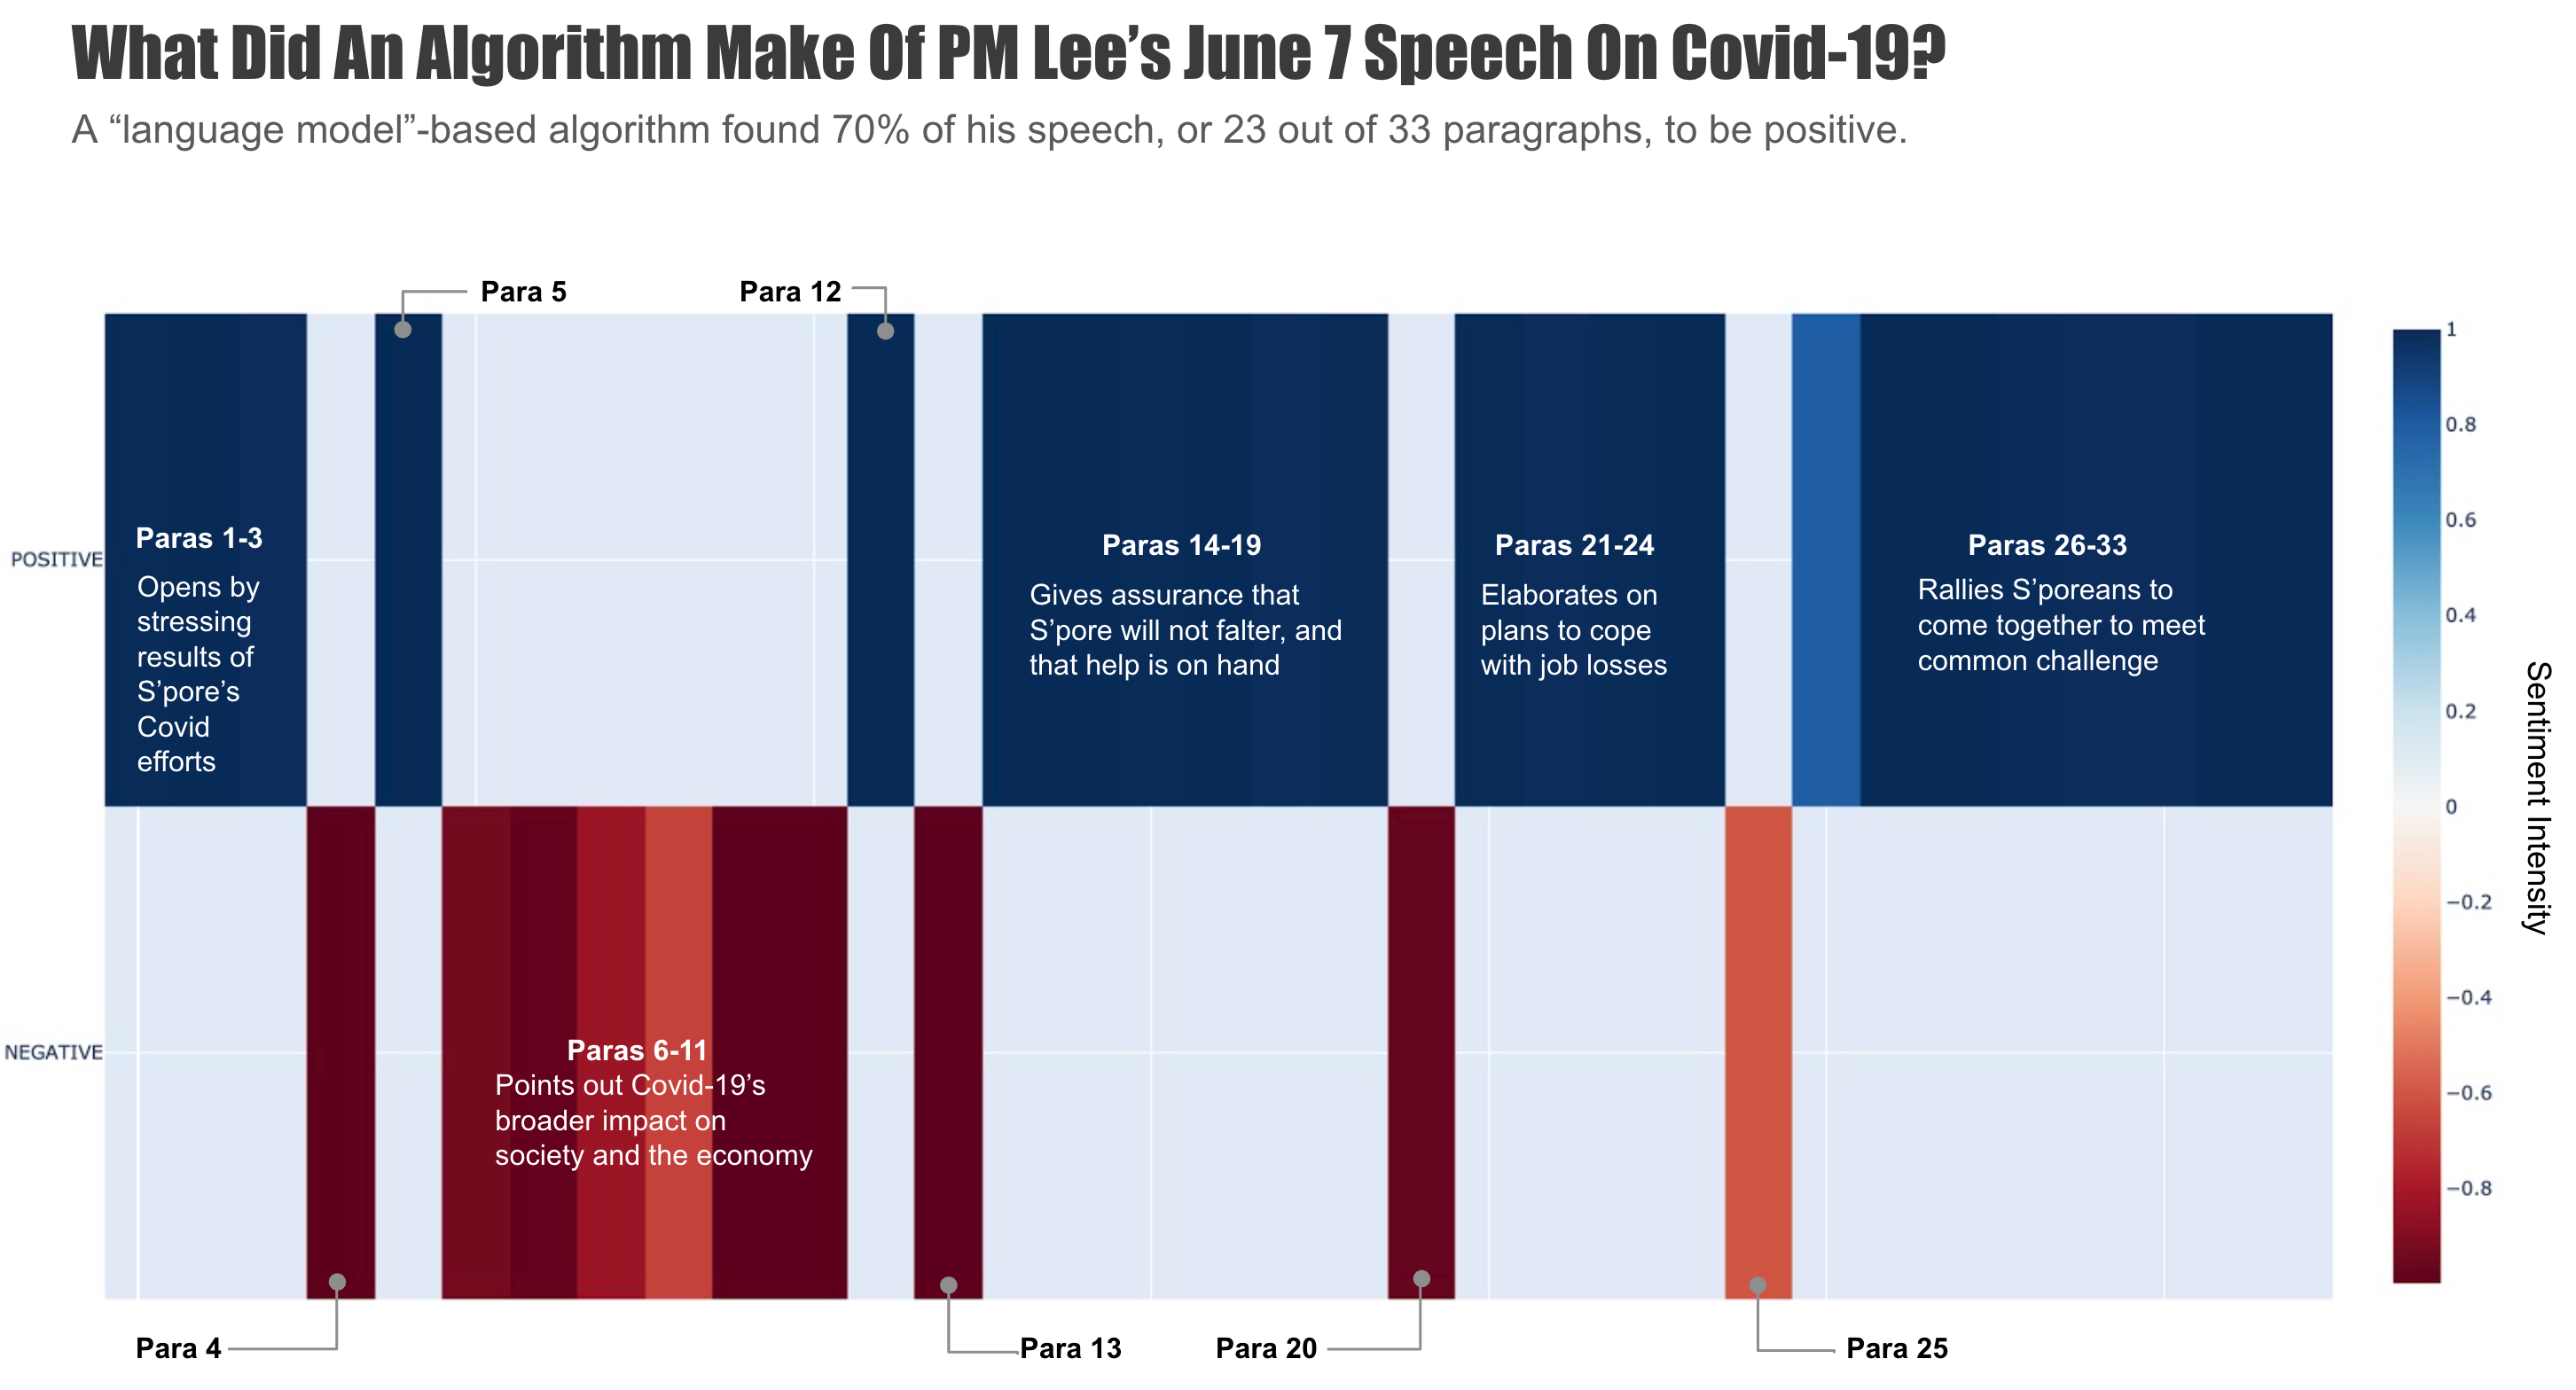

## 5.2 SPOTTING MISTAKES 

Proper annotation allows you to flag where the model's predictions went wrong, or where you may feel that the results are disputable. This transparency is important if you are presenting the results to an audience.

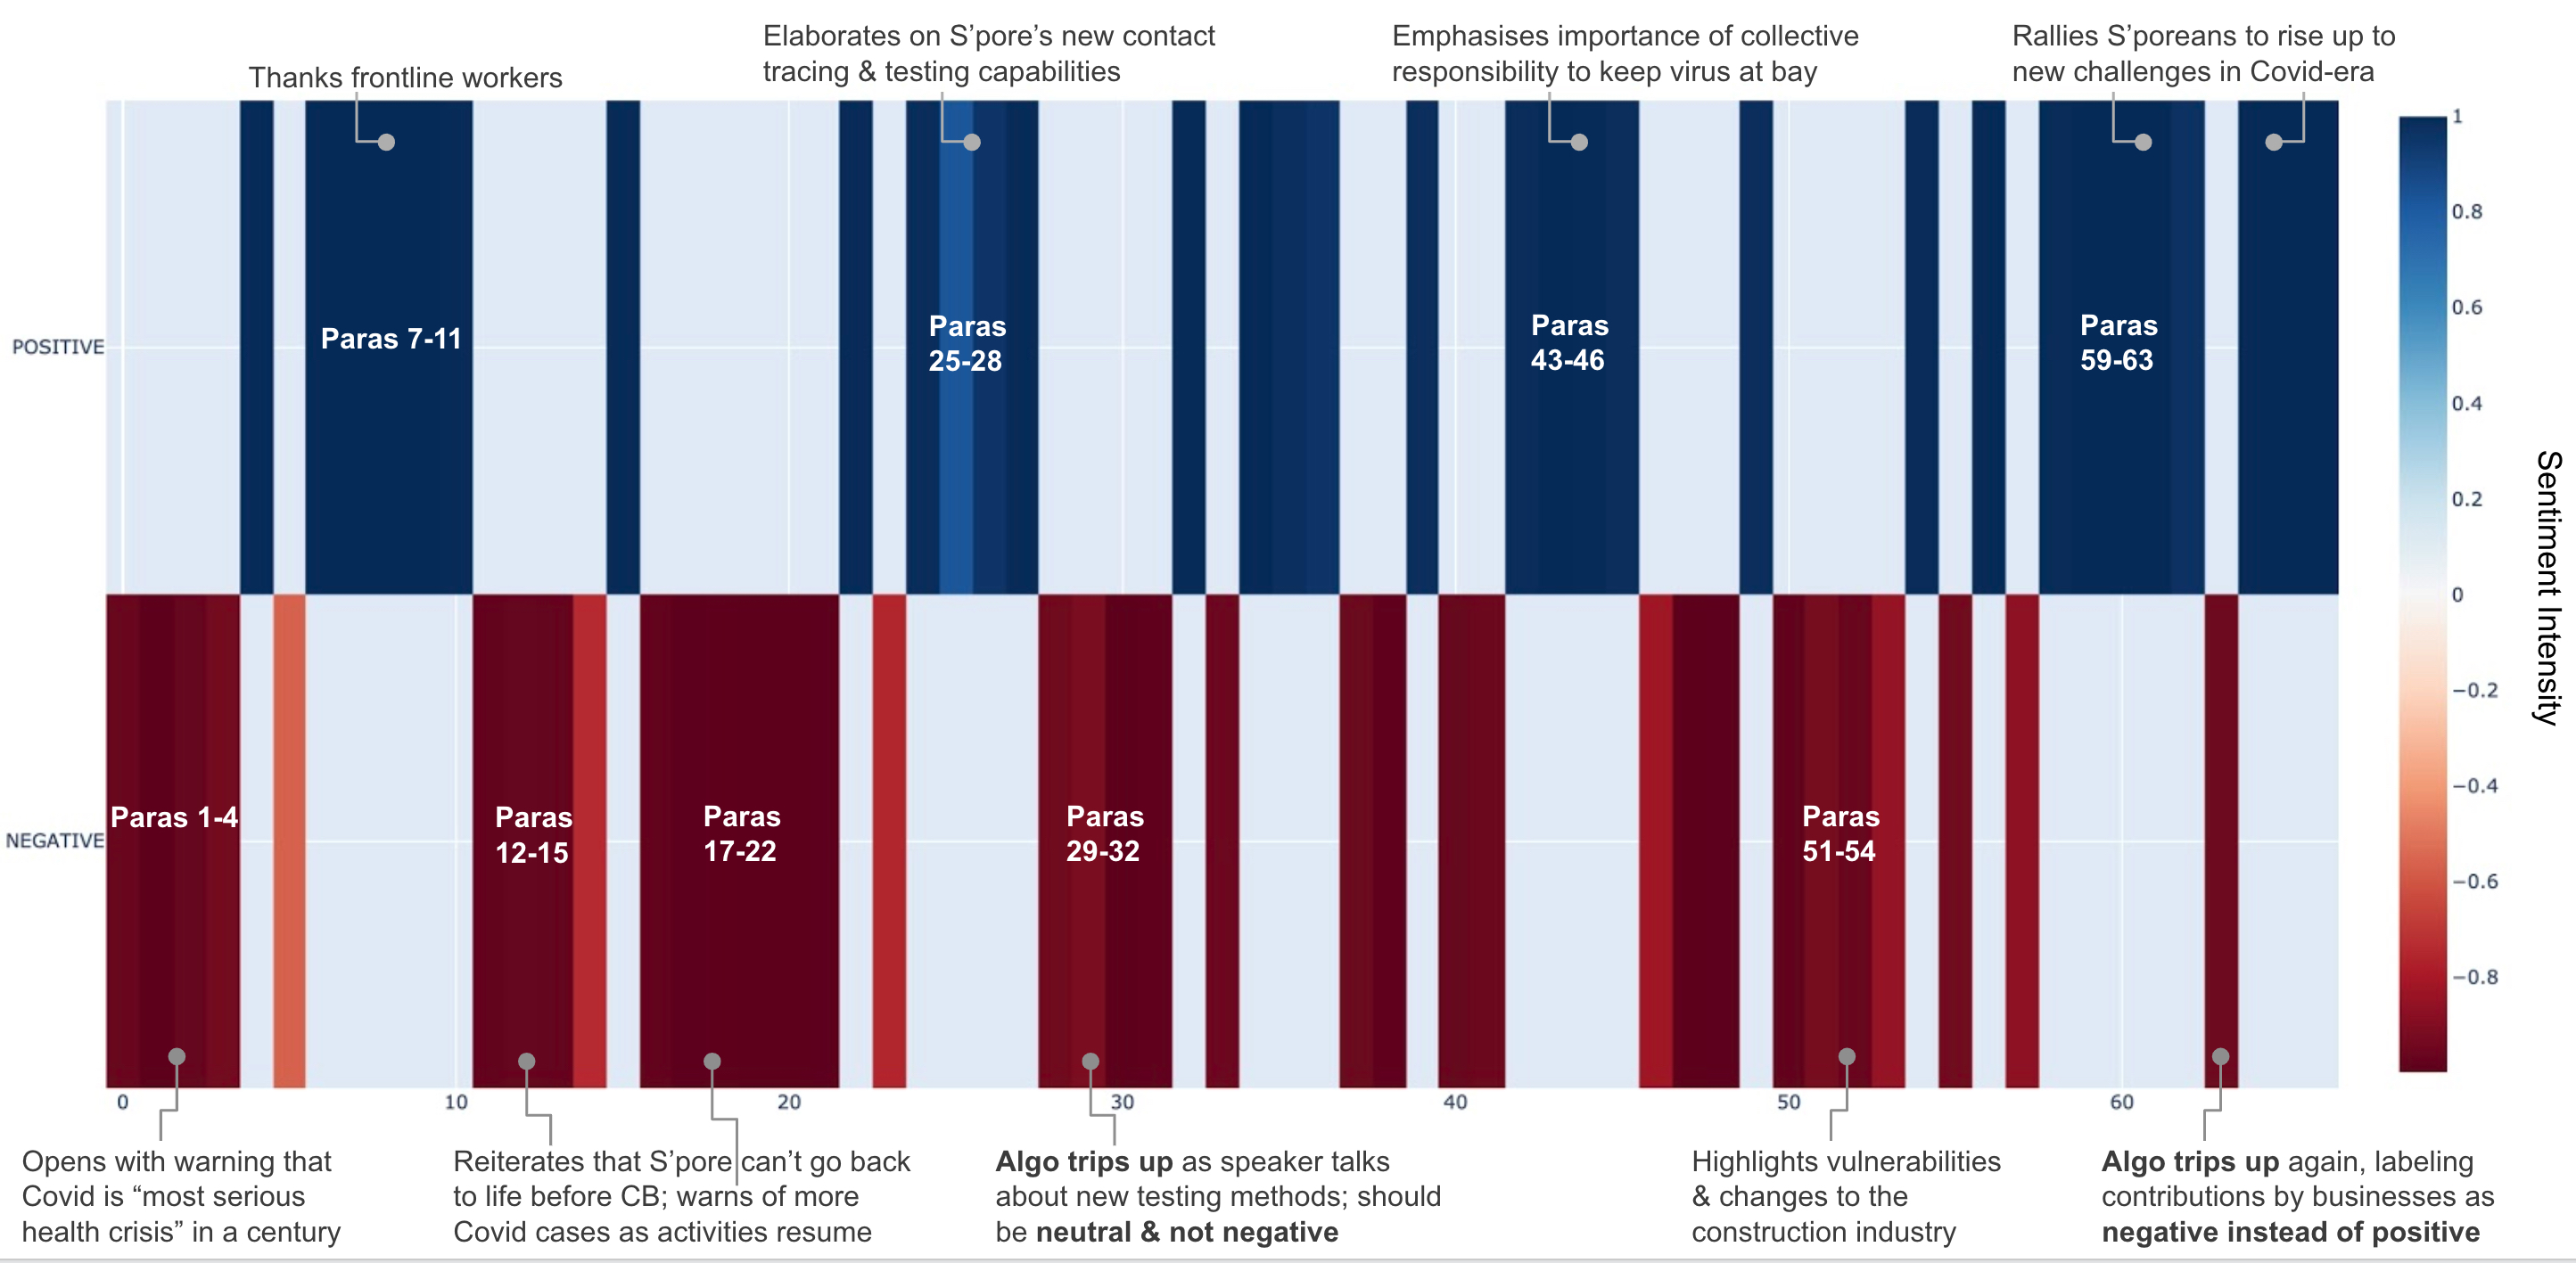

## 5.3 ANALYSING LONG TERM TRENDS

What I find useful with this approach is that you can just as quickly adapt it to analyse speeches over a longer timeline. By grouping individual "sentiment structure" charts together, you can see how the sentiment on a subject shifted over time.

The chart below shows how political leaders in Singapore changed the tone of their speeches on Covid-19 between February and June, ahead of expected polls.

You can easily apply this to, say, Trump's speeches on Covid-19 between the initial and later phases to see how he has flip-flopped on the matter. 

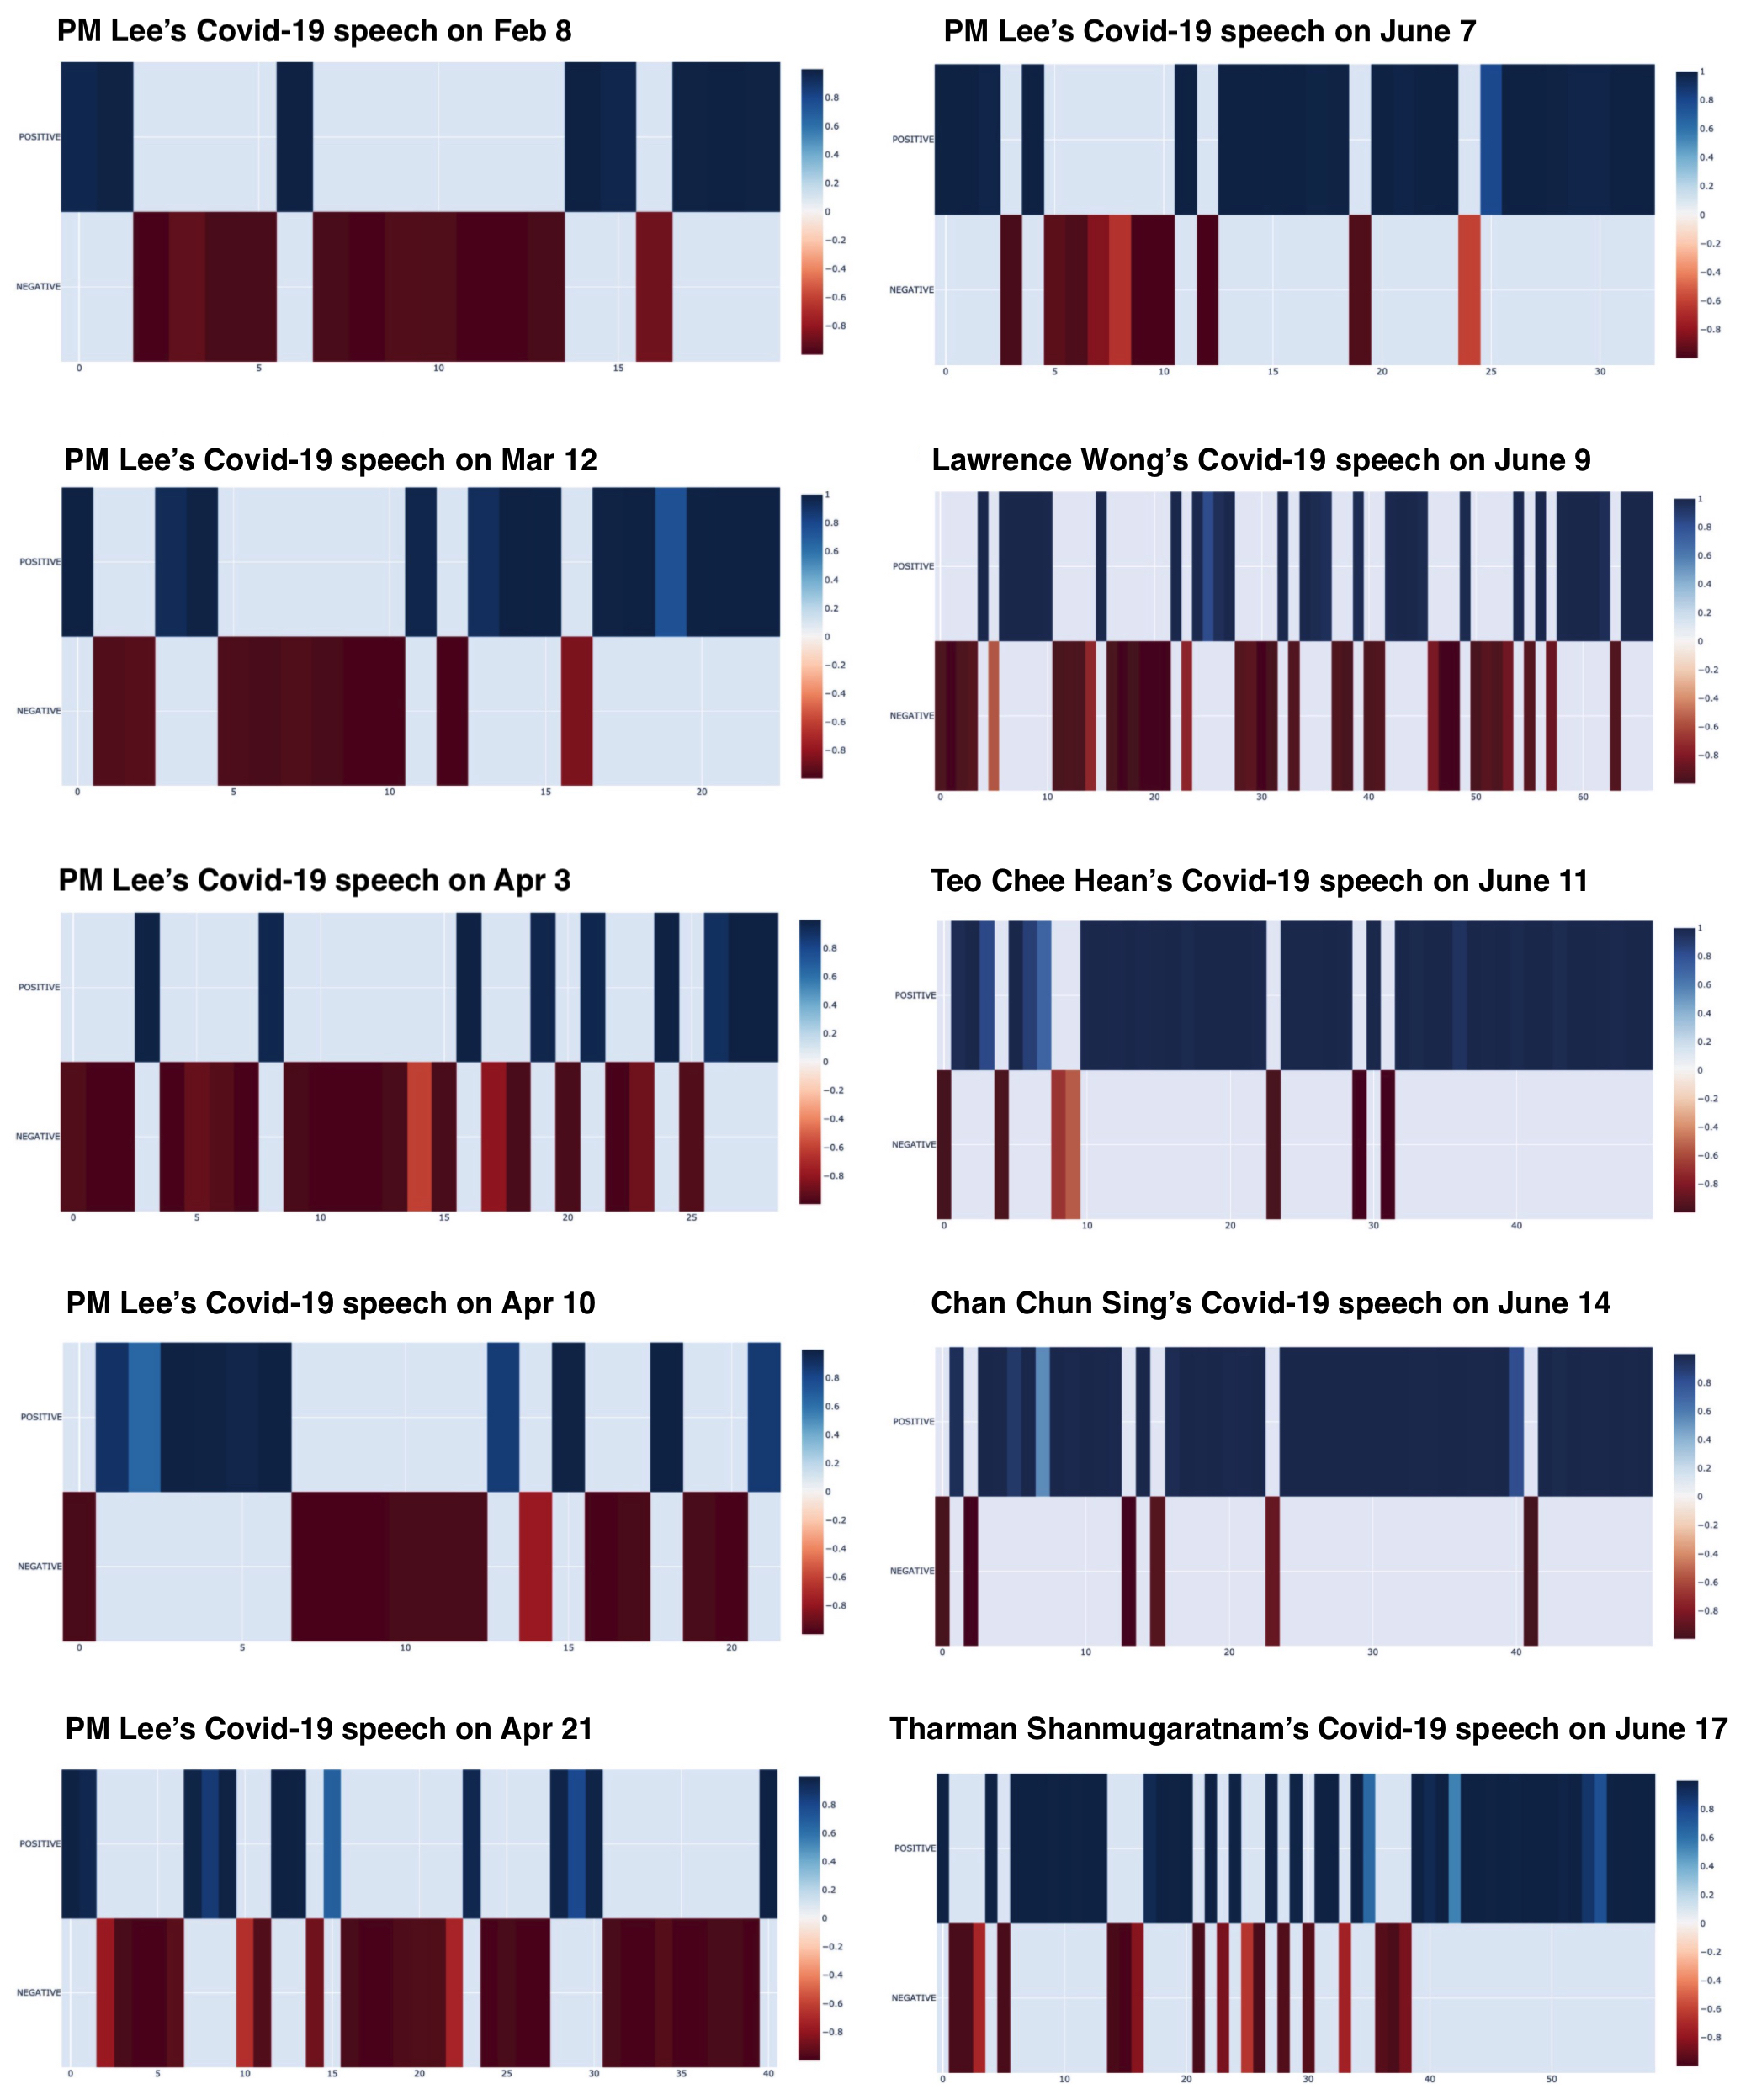

# 6. END NOTE

The code here stops at generating one chart. Write a for-loop or duplicate the notebook if you want to quickly churn out charts for a number of speeches in short order.

I prefer to examine the results for one speech before moving to the next. You'll probably need a different workflow if you are analysing tweets or social media comments in large numbers.

Ping me if you spot mistakes or do something interesting with this format:

* Twitter: @chinhon

LinkedIn: www.linkedin.com/in/chuachinhon